## Introduction

In this session, we will practice the development of solvers for physical systems. After a preliminary part dedicated to MAC grid operations and a simple visualization toolbox, we will dive into the internals of a fluid simulator, with the following components:
 1. Differential operators, finite volume advection, and pressure projection (classical Computer Graphics solver)
 2. Acceleration of the pressure computation with an unsupervised UNET

In [ ]:
# Change this global variable to switch between CPU/GPU usage in pytorch.
# Note: to save Collab GPU availability, GPU is not needed before part 3
use_gpu = False

### Part 0: Preliminaries

In [ ]:
## matplitlib and html5 embedding for visualization of simulations in a notebook
%matplotlib inline
from matplotlib import rc
rc('animation', html='html5')
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

## Pressure projection (in part 2 will require linear system solvers on the CPU from scipy)
import numpy as np
import math
import scipy.sparse
import scipy.sparse.linalg 

# pytorch
import torch
import torch.nn.functional as F

# TODO placeholder
import warnings
class TeacherWarning(UserWarning):
    pass
def TODO(x):
    warnings.warn("Please fill ...", TeacherWarning)
    return x
# device selection function
def device():
    global use_gpu
    if not use_gpu:
        return torch.device('cpu')
    if not torch.cuda.is_available():
        warnings.warn("GPU required but not available. Check the execution parameters of the collab notebook", TeacherWarning)
        return torch.device('cpu')
    return torch.device('cuda')
device()

device(type='cpu')

Fluid solvers handle various quantities (velocity, pressure, ...) and their derivatives. Here is a simple example that shows that this induces non-trivial discretizations: imagine that a physical quantity $u$ is stored at the center of the cells of a regular grid ($0, ..., i-1, i, i+1, ...$), and that we need to evaluate $u+\frac{\partial u}{\partial x}$. $\frac{\partial u}{\partial x}$ can be discretized as $\frac{u_{i+1}-u_{i-1}}{2dx}$, but this often leads to instabilities. Instead, one can evaluate $\frac{\partial u}{\partial x}$ at a virtual, intermediate location $\left(\frac{\partial u}{\partial x}\right)_{i+1/2} = \frac{u_{i+1}-u_{i}}{dx}$.

Choosing where to store the different quantities involved in fluid equations to minimize the amount of conversions from grid to mid-cell computations is not trivial. One of the common strategies is called the staggered Markers and Cells (MAC) discretization, where:      
 - pressure is stored at the center of the cell
 - horizontal velocity (vx) is stored on the vertical edges (x+1/2)
 - vertical velocity (vy) is stored on the horizontal edges (y+1/2)
   
**Q1**: Implement the functions that convert data stored in a MAC grid into alternative storage. You will need to average neighboring cells.
Reminder: PyTorch axis are accessed from right to left, *e.g.*, `u[y, x]`.

In [ ]:
# ux is stored at the on the vertical edges (x+1/2, y), outputs ux(x,y)
# (B, 1, H, W+1) ->  (B, 1, H, W)
MAC_edgex2center = lambda ux: (ux[:,:,:,:-1] + ux[:,:,:,1:])/2
# ux is stored at the on the vertical edges (x, y+1/2), outputs ux(x,y)
# (B, 1, H+1, W) ->  (B, 1, H, W)
MAC_edgey2center = lambda uy: (uy[:,:,:-1,:] + uy[:,:,1:,:])/2
# interpolate ux on horizontal edges 
# (input (B,1,H,W+1), output (B, 1, H-1, W))
MAC_edgex2edgey = lambda ux: (ux[:,:,:-1,:-1] + ux[:,:,1:,:-1] + ux[:,:,:-1,1:] + ux[:,:,1:,1:])/4
# interpolate uy on veritcal edges
# (input (B,1,H+1,W), output (B, 1, H, W-1))
MAC_edgey2edgex = lambda uy: (uy[:,:,:-1,:-1] + uy[:,:,1:,:-1] + uy[:,:,:-1,1:] + uy[:,:,1:,1:])/4

In the various stages of the practical, we will need to visualize the velocity field. We propose two means of visualization: we can display the norm of the velocity field, or its vorticity. 

**Q2**: Use the previous functions to return the field containing the Frobenius norm of the input (vx, vy) vectors, stored at the center of the cell.

In [ ]:
def vel_to_im(vx, vy, dx, visu_mode = "norm"): # or visu_mode = "vorticity"

    ## Q2: compute the norm(x,y) = ||(vx, vy)(x,y)||
    norm = torch.sqrt(MAC_edgex2center(vx)**2 + MAC_edgey2center(vy)**2)

    dvxdy = (vx[:, :, 1:, 1:-1] - vx[:, :, :-1, 1:-1])/dx # (B, 1, H, W+1) ->  (B, 1, H-1, W+1)
    dvydx = (vy[:, :, 1:-1, 1:] - vy[:, :, 1:-1, :-1])/dx # (B, 1, H+1, W) ->  (B, 1, H+1, W-1)

    vorticity_corners = dvydx - dvxdy
    # Convert from pytorch to CPU numpy for visualization
    return np.array((vorticity_corners if visu_mode == 'vorticity' else norm).detach().cpu())[0, 0]

SimuDislay is a class design to display simulation, using the animation modules of matplotlib.

In [ ]:
class SimuDisplay:

    def __init__(self, width, visu_mode = "norm"):

        self.visu_mode = visu_mode

        # The simulation domain will be square, of dimension (width x width)        
        self.width = width

        self.dx = 1

        # a subclass should implement init_velocity() to initialize vx, vy
        self.vx, self.vy = self.init_velocity()

        # Initialize the matplotlib plot that will be updated by the animation
        self.fig, self.ax = plt.subplots()
        vmax = 1
        if self.visu_mode == 'vorticity':
            cmap, vmin = "seismic", -vmax
        else:
            cmap, vmin = "plasma", 0

        self.im = self.ax.imshow(vel_to_im(self.vx, self.vy, self.dx), vmin = vmin, vmax =vmax, origin = 'lower', cmap = cmap)
        plt.axis('off')

        # update callback. calls a function 'update(self, vx, vy, frame)', implemented in subclasses
        def update_func(frame):
            if frame > 0:
                self.vx, self.vy = self.update(self.vx, self.vy, frame)
                self.im.set_array(vel_to_im(self.vx, self.vy, self.dx, self.visu_mode))
            return (self.im,)

        self.update_func = update_func
            
    def show(self, num_frames):
        # display the simulation for num_frames frames
        return FuncAnimation(self.fig, self.update_func, frames=np.arange(num_frames), blit=True, interval = 1000/25)

    def run(self, num_frames):
        # run the simulation for num_frames frames, without displaying it
        for k in range(num_frames):
            self.update_func(k)

**Q3**: Write a subclass for SimuDisplay that display an simple animated velocity field, (e.g. `vy = 0; vx = sin(frame/10 + 3*y); y in [-1,1]`).

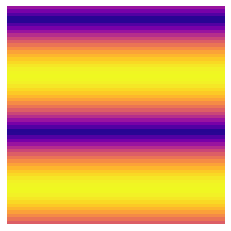

In [ ]:
class SimuDisplayTest(SimuDisplay):

    def __init__(self, width = 64, visu_mode = "norm"):
        super().__init__(width, visu_mode)

    def init_velocity(self):
        # Q3.1 Initialize the velocities with the right shape
        ux = torch.zeros((1, 1, self.width, self.width + 1))
        uy = torch.zeros((1, 1, self.width + 1, self.width))
        return ux, uy

    def update(self, ux, uy, frame):
        # Q3.2 generate a simple animation for the velocity
        y = torch.linspace(-1, 1, self.width)
        ux = 0*ux + torch.sin(frame/10 + 3*y)[None, None, :, None]
        return ux, uy

test = SimuDisplayTest(visu_mode = "norm")
test.show(100)

### Part 1: Fluid simulation

Now, let us dive into the core elements of the fluid solver, starting from the implementation of the differential operators.

**Q4**: Implement the gradient of a scalar field.

In [ ]:
def grad(s, dx):
    """
    Input: s is a scalar field stored in a centered grid (dim: b, 1, h, w)
    Output: gradient of s in each direction stored on the edges of the grid: ds/dx (dim: b, 1, h, w-1), ds/dy (dim: b, 1, h-1, w)
    """
    # Q4: implement the gradient
    dsdx = (s[:,:,:,1:] - s[:,:,:,:-1]) / dx
    dsdy = (s[:,:,1:,:] - s[:,:,:-1,:]) / dx
    
    return (dsdx, dsdy)

Q5: Implement the divergence of a vector field.

In [ ]:
def div(vx, vy, dx):
    """
    Input: vx, vy are the x, and y components of a vector field stored in a the edges of the grid u:(b, 1, h, w+1), v:(b, 1, h+1, w)
    Output: div(v)=du/dx+dv/dy (dim: b, 1, h, w)
    """
    # Q5: implement the divergence
    div_v = (vx[:,:,:,1:] - vx[:,:,:,:-1]) / dx + (vy[:,:,1:,:] - vy[:,:,:-1,:]) / dx
    return div_v

We will now implement the advection. One option is to implement the semi-lagrangian advection with pytorch buit-in interpolation, but we will prefer here the more conservative upwind scheme.

The equation is:
$$
\frac{\partial \mathbf u}{\partial t}+\mathbf u \cdot \nabla \mathbf u = 0
$$
Where $\mathbf u \cdot \nabla \mathbf u$ is expended as
$$
u_x\frac{\partial \mathbf u_x}{\partial x}+u_y\frac{\partial \mathbf u_x}{\partial y}
$$
$$
u_x\frac{\partial \mathbf u_y}{\partial x}+u_y\frac{\partial \mathbf u_y}{\partial y}
$$
The terms $u_x\frac{\partial \mathbf u_x}{\partial x}$ and $u_y\frac{\partial \mathbf u_y}{\partial y}$ are straightforward to compute on the staggered grid with the upwind scheme:
 $$
u_x(x+1/2,y)\frac{\partial u_x}{\partial x}(x, y) \text{ if } u_x(x+1/2,y)>0
$$ $$
u_x(x+1/2,y)\frac{\partial u_x}{\partial x}(x+1, y) \text{ else } 
$$
But the crossed term need to remap to the other grid:
 $$
u_y(x+1/2,y)\frac{\partial u_x}{\partial y}(x+1/2, y-1/2) \text{ if } u_y(x+1/2,y)>0
$$ 
 $$
u_y(x+1/2,y)\frac{\partial u_x}{\partial y}(x+1/2, y+1/2) \text{ else }
$$ 

**Q6**: Implement the velocity self-advection.

In [ ]:
def advect(ux, uy, dx, dt):
    """
    ux, uy are the velocities on the staggered grid: ux(B, 1, H, W+1), uy(B, 1, H+1, W)
    computes u(t) - dt * dot(u, nabla u) and returns it inside the domain: ux_out(B, 1, H-2, W-1), uy_out(B, 1, H-1, W-2)
    """

    # du_i/dx_j
    duxdx = (ux[:, :, :, 1:] - ux[:, :, :, :-1])/dx # (B, 1, H, W)
    duydx = (uy[:, :, :, 1:] - uy[:, :, :, :-1])/dx # (B, 1, H+1, W-1)
    duxdy = (ux[:, :, 1:, :] - ux[:, :, :-1, :])/dx # (B, 1, H-1, W+1)
    duydy = (uy[:, :, 1:, :] - uy[:, :, :-1, :])/dx # (B, 1, H, W)

    # Q6.1 Evaluate ux and uy on the axis-inverted staggered grid (see MAC_edgex2edgey and MAC_edgey2edgex above)
    ux_yg = MAC_edgex2edgey(ux)  #(B, 1, H-1, W)
    uy_xg = MAC_edgey2edgex(uy)  #(B, 1, H, W-1)

    # Q6.2 compute ux dux/dx and uy duy/dy upwind (hint: use torch.where)
    uxduxdx = ux[:, :, :, 1:-1] * torch.where(ux[:, :, :, 1:-1] > 0, duxdx[:, :, :, :-1], duxdx[:, :, :, 1:]) #(B, 1, H, W-1)
    uyduydy = uy[:, :, 1:-1, :] * torch.where(uy[:, :, 1:-1, :] > 0, duydy[:, :, :-1, :], duydy[:, :, 1:, :]) #(B, 1, H-1, W)
    
    # Q6.3 compute uy dux/duy (on x grid) and ux duy/dux (on y grid) upwind
    # TODO((uy_xg, duxdy)) (B, 1, H-2, W-1)
    uyduxdy = uy_xg[:, :, 1:-1, :] * torch.where(uy_xg[:, :, 1:-1, :] > 0, duxdy[:, :, :-1, 1:-1], duxdy[:, :, 1:, 1:-1])
    # TODO((ux_yg, duydx)) (B, 1, H-1, W-2)
    uxduydx = ux_yg[:, :, :, 1:-1] * torch.where(ux_yg[:, :, :, 1:-1] > 0, duydx[:, :, 1:-1, :-1], duydx[:, :, 1:-1, 1:])

    # compute u dot nabla u
    u_nabla_ux = uxduxdx[:, :, 1:-1, :] + uyduxdy  #(B, 1, H-2, W-1)
    u_nabla_uy = uxduydx + uyduydy[:, :, :, 1:-1]  #(B, 1, H-1, W-2)

    # return u advected (inline)
    return ux[:, :, 1:-1, 1:-1] - dt * u_nabla_ux,  uy[:, :, 1:-1, 1:-1] - dt * u_nabla_uy

We impose Neuman boundary conditions for the velocities everywhere except in a small prescribed inflow on the left side.

In [ ]:
def boundary_conditions_advect(ux, uy):

    # Apply Neumann boundary conditions at the bounds

    for e, i in [(0, 1), (-1, -2)]:
        ux[:, :, e, :] = ux[:, :, i, :] # dux/duy = 0
        uy[:, :, :, e] = uy[:, :, :, i] # duy/dux = 0
    for e, i in [(0, 1), (-1, -2)]: #order is important to bring information up to the corners
        ux[:, :, :, e] = ux[:, :, :, i] # dux/dux = 0
        uy[:, :, e, :] = uy[:, :, i, :] # duy/duy = 0
            



A last step for a stable advection is to compute a time step that respects the CFL condtion:    
$$
dt = min(dt_{max}, C\, dx/max(max(|u_x|,|u_y|)))
$$
**Q7**: Compute the maximum dt from the CFL condition

In [ ]:
def cfl(ux, uy, dx, C,dt_max):
    # Q7: compute dt that respects the CFL
    dt = min(dt_max, C*dx/max(torch.max(torch.abs(ux)), torch.max(torch.abs(uy))))
    return dt

Then we visualize a self-advected field. We initialize the velocities with non zero values and add a small force in the middle to make the flow more interesting.

Note that the density $\rho$ is implicitely set to 1 everywhere

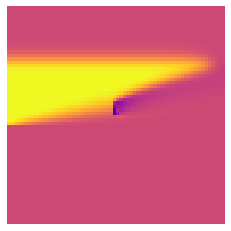

In [ ]:
class SimuAdvectOnly(SimuDisplay):

    def __init__(self, width = 64, visu_mode = "norm"):
        super().__init__(width, visu_mode)
        
        # Simulation parameters
        self.cfl = .5
        self.dx = 1
        self.dt_max = 1
        self.inflow_radius = 3
        self.inflow_from = self.width//2 - int(self.inflow_radius)
        self.inflow_to = self.inflow_from + 2 * int(self.inflow_radius)
        self.inflow_value_x = 1
        self.inflow_value_y = .2

    def init_velocity(self):
        # initialize the velocity field
        ux = torch.zeros((1, 1, self.width, self.width+1), requires_grad=False, device = device()) +.5
        uy = torch.zeros((1, 1, self.width+1, self.width), requires_grad=False, device = device()) +.1

        # create force coefficients
        self.fx = torch.zeros_like(ux)
        self.fy = torch.zeros_like(uy)
        mid = self.width//2
        self.fx[0, 0, mid:mid+2, mid] = .5
        self.fy[0, 0, mid, mid:mid+2] = .5

        return ux, uy

    def update(self, ux, uy, frame, apply_bc = True):

        # compute next time step
        self.dt = cfl(ux, uy, self.cfl, self.dx, self.dt_max)

        # set the inflow:
        ux[:, :, self.inflow_from  :self.inflow_to, 0] = self.inflow_value_x
        uy[:, :, self.inflow_from+1:self.inflow_to, 0] = self.inflow_value_y

        # advect the velocity
        ux[:, :, 1:-1, 1:-1], uy[:, :, 1:-1, 1:-1] = advect(ux, uy, self.dx, self.dt)

        # add forces
        ux -= self.dt * self.fx*(ux - (-1))
        uy -= self.dt * self.fy*(uy - .5)

        # set boundary conditions
        if apply_bc:
            boundary_conditions_advect(ux, uy)

        # return the velocity field
        return ux, uy


test = SimuAdvectOnly(visu_mode = "norm")
test.show(200)

The core component of a fluid simulation is the pressure. We will now use scipy to implement the pressure projection method. Remember that we need to solve

$$
\frac{\partial u}{\partial t} + u \cdot \nabla u = -\frac{1}{\rho} \nabla p
$$
We compute the velocity in two steps. First, we compute an intermediate velocity:
$$
u^* = u(t) - dt\,u \cdot \nabla u
$$
Then, we update the velocity with:
$$
u(t+dt) = u^*  -\frac{dt}{\rho} \nabla p
$$
To compute the pressure, we take the divergence of the above equation:
$$
0 = \nabla \cdot u^* -\frac{dt}{\rho} \Delta p
$$

We also need to set the boundary conditions for the pressure: $p=0$ on all bounds, except for the inflow, where $\partial p/\partial x=0$

Note: here we use a modified pressure instead: $p^* = p\, dt/\rho$, which enable us to remove $dt/\rho$ from the equations.

**Q8**: The sparse matrix for the laplacien will be computed for you. Implement the function that compute the pressure.


In [ ]:
def pressure(dx, w, h, inflow_from, inflow_to):

    """
    Input: dx, w, h (size of the domain), inflow_from, inflow_to: bounds of the inflow vertical coordinates
    Ouput: function that compute the pressure
    """

    ### Create the matrix in COO format
    r = np.arange(0, w)[None, :] + np.arange(0, h)[:, None] * w
    f = lambda x : x.reshape(-1)

    row = np.concatenate([
        f(r[:, :]), f(r[:, :-1]), 
        f(r[:, ]),  f(r[:, 1:]), 
        f(r[:, :]), f(r[:-1, :]), 
        f(r[:, :]),  f(r[1:, :]), 
        f(r[inflow_from:inflow_to, 0]) # dirichlet boundaries everywhere, except for the inflow: remove  '-1' from the diagonal 
    ])

    col = np.concatenate([
        f(r[:, :]), f(r[:, 1:]), 
        f(r[:, :]),  f(r[:, :-1]), 
        f(r[:, :]), f(r[1:, :]), 
        f(r[:, :]),  f(r[:-1, :]), 
        f(r[inflow_from:inflow_to, 0])
    ])

    one     = np.ones(h*w, dtype = float)
    one_wm1 = np.ones(h*(w-1), dtype = float)
    one_hm1 = np.ones(w*(h-1), dtype = float)

    data = np.concatenate([
        -one, one_wm1,
        -one, one_wm1,
        -one, one_hm1,
        -one, one_hm1,
        np.ones(inflow_to-inflow_from, dtype = float)
    ])

    mat = scipy.sparse.coo_matrix((data, (row, col))).tocsr() / (dx*dx)

    def get_p(div_u, p_guess):
        """
        Input: div(u), initial guess for the pressure
        Ouput: p
        """

        shape = p_guess.shape

        # convert the input to a flattened 1d numpy array
        div_u = div_u.reshape(-1).detach().cpu().numpy()
        p_guess = p_guess.reshape(-1).detach().cpu().numpy()

        # Q8: Compute the pressure (hint: find the conjugate gradient solver from scipy.sparse.linalg)
        # provide p_guess as an initail guess for the pressure

        #p = TODO((mat, div_u, p_guess))
        p = scipy.sparse.linalg.cg(mat, div_u, p_guess)[0]

        # send the result back as a 2d torch tensor
        return torch.tensor(p, device = device()).reshape(shape)

    return get_p


After computing the pressure p, we need to extend it on cirtual cells outside of the domain to compute the gradients with correct boundary condition: 

In [ ]:
def extend_pressure_bound(p, inflow_from, inflow_to):

    p = F.pad(p, (1,1,1,1)) # pad with 0 by default, consistent with our Dirichlet boundary condition

    # Von Neuman BC at the inflow 
    p[:, :, inflow_from+1:inflow_to+1, 0] = p[:, :, inflow_from+1:inflow_to+1, 1]

    return p


FInaly we build the pressure solver on top of the previous advection.

**Q9**: Correct the `update` function to incorporate the pressure projection

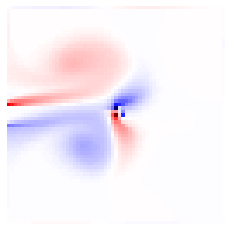

In [ ]:
from posixpath import pardir
class SimuPressure(SimuAdvectOnly):

    def __init__(self, width = 64, visu_mode = "norm"):
        super().__init__(width, visu_mode)
        self.pressure_func = pressure(self.dx, self.width, self.width, self.inflow_from, self.inflow_to)

    def init_velocity(self):
        
        self.p = torch.zeros((1, 1, self.width, self.width))
        # use SimuAdvectOnly.init_velocity to intialize the velocities and forces
        # we change the initial velocity to 0, because pressure will be enough to make the fluid interesting
        ux, uy =  super().init_velocity()
        ux *= 0
        uy *= 0
        return ux, uy

    def update(self, ux, uy, frame):

        ux, uy = super().update(ux, uy, frame, apply_bc = False)

        # Q9: use self.pressure_func, div, grad, and extend_pressure_bound to implement the pressure correction

        # ux, uy = TODO((ux, uy))
        p = extend_pressure_bound(self.pressure_func(div(ux, uy, self.dx), self.p), self.inflow_from, self.inflow_to)
        g = grad(p, self.dx)
        ux, uy = ux - g[0][:,:,1:-1,:], uy - g[1][:,:,:,1:-1]

        return ux, uy

test = SimuPressure(visu_mode = "vorticity")
test.show(200)

Unfortunately, increasing the dimensions will make the solver very slow (especially with conjugate gradient).
Let us try with a larger (256x256) domain, for a few frames.

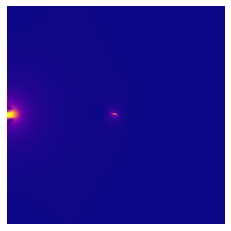

In [ ]:
test = SimuPressure(width = 256)
test.show(50)

### Part 2: Learn the pressure

In this part, we will use a U-Net to predict the pressure from the advected velocity, and train it with an unsupervised loss.

First, we construct a general purpose UNET class:

In [ ]:
# unet utils

# 3x3 convolution, followed by an activation function (ReLU by default)
def conv( in_channels, out_channels, activation = None):
    return torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1), activation if activation is not None else torch.nn.ReLU())   

# 2x2 average pooling for downsampling
def down():
    return torch.nn.AvgPool2d(2, stride=2, padding=0)
# x2 bilinear upsampling
def up():
    return torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

# wrapper for convolutions with concatenated skip connections
class skip_and_conv(torch.nn.Module):
    def __init__(self, in_a_channels, in_b_channels, out_channels):
        super().__init__()
        self.conv = conv(in_a_channels+ in_b_channels, out_channels)
    def forward(self, a, b):
        return self.conv(torch.cat((a, b), dim = 1))

# u-Net network
class UNET(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv_e0  = conv(in_channels, 32)
        self.conv_e1  = conv(32, 64)
        self.conv_e2  = conv(64, 128)
        self.conv_e3  = conv(128, 128)

        self.conv_b40  = conv(128, 128)
        self.conv_b41  = conv(128, 128)
        self.conv_b42  = conv(128, 128)

        self.conv_d3  = skip_and_conv(128, 128, 128)
        self.conv_d2  = skip_and_conv(128, 128, 64)
        self.conv_d1  = skip_and_conv(64, 64, 32)
        self.conv_d0  = skip_and_conv(32, 32, 16)

        self.conv_end0  = conv(16, 16)
        self.conv_end1  = conv(16, 16)

        self.final = conv(16, out_channels, activation = torch.nn.Identity())

    def __call__(self, x):

        # downsample
        x0 = self.conv_e0(x)
        x1 = self.conv_e1(down()(x0))
        x2 = self.conv_e2(down()(x1))
        x3 = self.conv_e3(down()(x2))

        # bottleneck
        x = self.conv_b40(down()(x3))
        x = self.conv_b41(x)
        x = self.conv_b42(x)

        # upsample and skip
        x = self.conv_d3(up()(x), x3)
        x = self.conv_d2(up()(x), x2)
        x = self.conv_d1(up()(x), x1)
        x =  self.conv_d0(up()(x), x0)

        # final linear conv layer
        x =  self.final(x)

        return x

Then, we create encapsulate this network into a `BaseFluidNet` class that takes as input a velocity field on a staggered  grid and outputs an (hopefully) divergent free velocity and a pressure.

The difficulty is to handle the staggered grid representation. One option is to give 4 input to the network (vx_left, vx_right, vy_bottom, vy_top), and ask for 5 outputs (same + pressure). We can then reconstruct the velocity field by averaging the values shared by a common edge.

**Q10**: Complete the `forward` function to take as input a velocity in a staggered grid, and output the velocity and the pressure.

In [ ]:
class BaseFluidNet(torch.nn.Module):   
    def __init__(self, dx, inflow_from, inflow_to):
        super().__init__()

        self.dx = dx
        self.inflow_from, self.inflow_to = inflow_from, inflow_to
        self.unet = UNET(4, 5)

    def forward(self, ux, uy):
        """
        Input: advected (intermediate) velocity (vx: (B, 1, H, W+1), vy: (B, 1, H+1, W))
        Output: divergence free velocity and pressure
        """

        # Q10: Compute the input and output to the network

        b = ux.shape[0]
        h = ux.shape[2]
        w = uy.shape[3]
        #unet_input = TODO((ux, uy))
        unet_input = torch.zeros((b, 4, h, w)) # (B, 4, H, W)
        for i in range(b):
          for j in range(h):
            for k in range(w-1):
              unet_input[i,0,j,k] = ux[i,0,j,k]

        for i in range(b):
          for j in range(h):
            for k in range(1,w):
              unet_input[i,1,j,k] = ux[i,0,j,k]   

        for i in range(b):
          for j in range(h-1):
            for k in range(w):
              unet_input[i,2,j,k] = ux[i,0,j,k] 

        for i in range(b):
          for j in range(1,h):
            for k in range(w):
              unet_input[i,3,j,k] = ux[i,0,j,k]

        unet_out = self.unet(unet_input) # (B, 5, H, W)

        vout_x = torch.zeros((b, 1, h, w+1)) # (B, 1, H, W+1)
  
        vout_x[:,0,:,0] = unet_out[:,0,:,0]
        vout_x[:,0,:,1:-1] = (unet_out[:,0,:,1:] + unet_out[:,1,:,:-1]) / 2 
        vout_x[:,0,:,-1] = unet_out[:,1,:,-1]

        
        vout_y = torch.zeros((b, 1, h+1, w)) # (B, 1, H+1, W)
        
        vout_y[:,0,0,:] = unet_out[:,2,0,:]
        vout_y[:,0,1:-1,:] = (unet_out[:,2,1:,:] + unet_out[:,3,:-1,:]) / 2 
        vout_y[:,0,:-1,:] = unet_out[:,3,-1,:]

        p = torch.zeros((b,1,h,w))
        p[:,0,:,:] = unet_out[:,4,:,:]      # (B, 1, H, W)

        return vout_x, vout_y, p
        

Then, we construct a subclass `FluidNet`, that also contain the necessary functions for unsupervised training.

Note that the predicted velocities are such that:
$$
u_{pred} = u_{input} - \nabla p
$$

**Q11**: Compute the residual in `residual_velocity`:
$$
u_{r} = u_{input} - (u_{pred} + \nabla p) 
$$

**Q12**: Compute a loss that aims to minimize $u_r$ and $\nabla \cdot u_{pred}$ 

In [ ]:
class FluidNet(BaseFluidNet ):   
    def __init__(self, dx, inflow_from, inflow_to):
        super().__init__(dx, inflow_from, inflow_to)

    def residual_velocity(self, ux, uy):
        """
        estimate the corrected velocities upred and compute the residual :ur = upred+grad p -u
        Outputs upred and ur
        """

        upred_x, upred_y, p = self(ux, uy)

        # Q 11: compute the residual
        # rx, ry = TODO((upred_x, (upred_y, p)))
        ep = extend_pressure_bound(p, self.inflow_from, self.inflow_to)
        g = grad(ep, self.dx)
        rx, ry = upred_x + g[0][:,:,1:-1,:] - ux, upred_y + g[1][:,:,:,1:-1] - uy
        
        return upred_x, upred_y, rx, ry

    def loss(self, vx, vy, div_weight):

        ux, uy, rx, ry = self.residual_velocity(vx, vy)
        # Q 12: compute a loss for the velocity residual and one for the divergence
        #vloss = TODO((rx, ry))
        loss_func1 = torch.nn.L1Loss()
        vloss = loss_func1(torch.sqrt(rx**2+ry**2), 0)
        #dloss = TODO((ux, uy))
        loss_func2 = torch.nn.L1Loss()
        dloss = loss_func2(div(ux, uy, self.dx), 0)

        return vloss + div_weight * dloss, vloss, div_weight * dloss

Optimally, we would like to train the network in a fully unsupervised way, where the dataset is incrementally constructed while the simulation progress. 

However, this strategy does not converge well in practice. Here, we will do a few simplifications:

 1. We will run the simulation multiple times with a limited amout of frames, to minimize the data manifold that we need to cover
 2. We will create a companion netwok that will overfit on each frame to bring the simulation closer to the divergent free trajectories. Ideally, at each epoch, we will need less and less overfiting, and not at all when the network is fully trained  

In [ ]:
import copy
class NeuralPressureOverfit:

    def __init__(self, copy_model, iter, div_weight):
        self.iter = iter
        self.div_weight = div_weight
        self.model = copy.deepcopy(copy_model)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0005, )
        self.losses = []

    def is_needed(self):
        return self.iter > 0

    def optimize(self, vx, vy):
        vloss, dloss = 0, 0
        for _ in range(self.iter):
            self.optimizer.zero_grad()
            loss, vloss, dloss = self.model.loss(vx.detach(), vy.detach(), self.div_weight)
            loss.backward()
            self.optimizer.step()
            vloss += math.sqrt(vloss.item()) 
            dloss += math.sqrt(dloss.item()) 
        self.losses.append((vloss.item() / self.iter, dloss.item() / self.iter))
        return self.model(vx, vy)

Now we have all the elments to train the pressure network.
Note that, because of the unsupervised strategy, we are able to predict the error for each cell (the above residual). 
And because the equations are linear, we can apply the overfitting stratgey directly on the residual.

**Q13**: in the `update` function, implement the overfitting strategy on the residuals

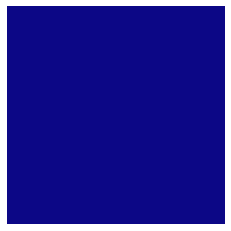

10


IndexError: ignored

In [ ]:
class SimuLearnPressure(SimuAdvectOnly):

    def __init__(self, width = 64):
        super().__init__(width)

        # fluid network and training parameters
        self.fluidnet = FluidNet(self.dx, self.inflow_from, self.inflow_to).to(device())
        self.optimizer = torch.optim.AdamW(self.fluidnet.parameters(), lr=0.0005, )
        self.dataset = []
        self.batch_size = 32
        self.losses = []
        self.data_set_max_len = 256
        self.div_weight = 1

        self.restart(10)

    def restart(self, inl):

        # restart will reset the overfitting network
        self.overfit = NeuralPressureOverfit(self.fluidnet, inl, self.div_weight)
        self.vx, self.vy = self.init_velocity()

    def init_velocity(self):
        ux, uy =  super().init_velocity()
        ux *= 0
        uy *= 0
        return ux, uy


    def add_to_dataset(self, vx, vy, batch_size):

        # add vx, vy to a batch of data
        if len(self.dataset) == 0 or self.dataset[-1][0].shape[0] == batch_size:
            self.dataset.append((vx.clone(), vy.clone()))
        else:
            self.dataset[-1] = (
                torch.cat([self.dataset[-1][0], vx]),
                torch.cat([self.dataset[-1][1], vy])
            )

        # The sze of the dataset is limited to a maximum value to bound the execution time. try with higher values!
        if len(self.dataset) > self.data_set_max_len:
            self.dataset = self.dataset[-self.data_set_max_len:]

    def train_batch(self, vx, vy):
        # train a batch
        self.optimizer.zero_grad()
        loss, vloss, dloss = self.fluidnet.loss(vx, vy, self.div_weight)
        loss.backward()
        self.optimizer.step()
        return math.sqrt(vloss.item()), math.sqrt(dloss.item())

    def epoch(self, num_iter=1):
        # train once over the whole dataset
        vloss, dloss = 0, 0
        for _ in range(num_iter):
            for vx, vy in self.dataset:
                vl, dl = self.train_batch(vx, vy)
                vloss += vl 
                dloss += dl
        return vloss / len(self.dataset) / num_iter, dloss / len(self.dataset) / num_iter


    def update(self, ux, uy, frame):

        ux, uy = super().update(ux, uy, frame, apply_bc = False)

        # add the advected ux, uy to the dataset
        self.add_to_dataset(ux, uy, self.batch_size)

        if self.overfit.is_needed():

            # compute the corrected velocities
            ux, uy, rx, ry = self.fluidnet.residual_velocity(ux, uy)
            # add the advected, corrected velocities to the dataset so that the network learns to fix its one mistakes
            tx, ty = super().update(ux, uy, frame, apply_bc = False)
            self.add_to_dataset(tx.detach(), ty.detach(), self.batch_size)

            # Q13: self.overfit to correct the residuals, then update the velocity.
            # ux, uy = TODO(((ux, uy), (rx, ry)))
            

        else:
            # if no overfitting is needed, just evaluate fluidnet
            ux, uy, p = self.fluidnet(ux, uy)

        return ux.clone().detach(), uy.clone().detach() # free graph


test = SimuLearnPressure(width = 32)
plt.show()

from IPython.display import display

# curriculum learning: train with 10 iterations of overfitting, then decreases toward 0
for inl in [10,10,5,5,2, 2, 1, 1, 0, 0]:
#for inl in [10]:
    print(inl)
    test.restart(inl)
    display(test.show(64))
    if test.overfit.is_needed():
        plt.plot(tuple(zip(*test.overfit.losses))[0])
        plt.plot(tuple(zip(*test.overfit.losses))[1])
    plt.show()
    lv, ld = zip(*[ test.epoch() for _ in range(75) ])
    plt.plot(lv)
    plt.plot(ld)
    plt.show()





### Bonus (curl):

[ These questions are not part of the grade, only here to explore a bit further ]
 - we can get ride of the divergence loss, if the network outputs a scalar _streamfunction_ $\phi$, such that $v=\nabla \phi $. Then $v$ will be divergence free by construction. Toi implement that, the streamfunction needs to be stored at the corners of the staggered grid. 

### Possible extensions for the project:

- Improve the (above) fluid solver. Possible extensions are: viscosity, liquid with surface tension, 3d fluids. Experiment with a differentiable longer term loss (the velocity needs to stay deivergence free after several advection?projection steps). The above training strategy might be hard to converge for more complicated example, the simplest would be to first construct a dataset of intermediate fluid velocities $v^*$
Inspiration: https://arxiv.org/pdf/1607.03597.pdf

- Train a PINN to solve the Navier stokes equations. Add an obstacle, for instance parametrized by its position, and add this parameter as an input to the PINN. 
Inspiration: https://maziarraissi.github.io/PINNs/

- Train a network (CNN) that learns the subcell corrections to a coarse simulation. You can build a database of corrections from a higher resolution simulation.
Inspiration: https://arxiv.org/abs/2007.00016